# 2D Fluid Flow for Keyholing Melt Pool

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

from jax import jit
from pint import Quantity
from tqdm import tqdm

## Domain
Defined in microns but can be converted to meters using pint

In [2]:
# Domain Lengths
lx = Quantity(1000, "microns")
ly = Quantity(1000, "microns")

lx_m = lx.to("m").magnitude
ly_m = ly.to("m").magnitude

print(f"lx: {lx} ({lx.to('m')}), ly: {ly} ({ly.to('m')})")

# Grid Spacings
dx = dy = Quantity(1, "micron")
print(f"dx: {dx} ({dx.to('m')}), dy: {dy} ({dy.to('m')})")

# Number of points
Nx, Ny = int(lx/dx), int(ly/dy)
print(f"Nx: {Nx}, Ny: {Ny}")

# Grid
x = jnp.linspace(0, lx_m, Nx+1)
y = jnp.linspace(0, ly_m, Ny+1)
print(f"x: {x}, y: {y}")

lx: 1000 micron (0.001 meter), ly: 1000 micron (0.001 meter)
dx: 1 micron (1e-06 meter), dy: 1 micron (1e-06 meter)
Nx: 1000, Ny: 1000
x: [0.0000000e+00 1.0000001e-06 2.0000002e-06 ... 9.9800015e-04 9.9900016e-04
 1.0000000e-03], y: [0.0000000e+00 1.0000001e-06 2.0000002e-06 ... 9.9800015e-04 9.9900016e-04
 1.0000000e-03]


## $\omega$ - [Vorticity](https://en.wikipedia.org/wiki/Vorticity) (for 2D flow)
$$\omega = \nabla \times \textbf{v} = \frac{\partial v}{\partial x} - \frac{\partial u}{\partial y}$$

In [3]:
# Vorticity (initialized as zeros)
omega = jnp.zeros((Nx + 1, Ny + 1))
print(f"omega: {omega}")

omega: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


transport equation:
$$\frac{\partial \omega}{\partial t} + u \cdot \nabla \omega = \nu \nabla^2 \omega$$

discrete time update:
$$\omega_{\text{new}} = \omega + \Delta t \left(-u \cdot \nabla \omega + \nu \nabla^2 \omega\right)$$

$$\omega^{n+1}_{i,j} = \omega^n_{i,j} + \Delta t \left[\nu \nabla^2 \omega - u \cdot \nabla \omega\right]^n_{i,j}$$

terms:
$$\text{conv} = u \nabla\omega$$
$$\text{diff} = \nu\nabla^2\omega$$


$$\omega^{n+1}_{i,j} = \omega^n_{i,j} + \Delta t \left[\text{diff} - \text{conv}\right]^n_{i,j}$$


In [4]:
from jax import jit

@jit
def update_vorticity(omega, u, v, nu, dx, dy, dt):
    """
    Vectorized update of vorticity (interior points).
    Inputs:
      - omega, u, v : jnp arrays shape (Nx+1, Ny+1)
      - nu, dx, dy, dt : floats (magnitudes, no pint.Quantity)
    """
    omega_new = omega.copy()

    i = slice(1, -1)
    j = slice(1, -1)

    # first derivatives (central)
    domegadx = (omega[2:, j] - omega[:-2, j]) / (2.0 * dx)
    domegady = (omega[i, 2:] - omega[i, :-2]) / (2.0 * dy)

    conv = u[i, j] * domegadx + v[i, j] * domegady

    # second derivatives (central)
    d2omegadx2 = (omega[2:, j] - 2.0 * omega[i, j] + omega[:-2, j]) / (dx * dx)
    d2omegady2 = (omega[i, 2:] - 2.0 * omega[i, j] + omega[i, :-2]) / (dy * dy)

    diff = nu * (d2omegadx2 + d2omegady2)

    omega_updated = omega[i, j] + dt * (-conv + diff)

    omega_new = omega_new.at[i, j].set(omega_updated)
    return omega_new

### Boundary conditions

No slip boundary conditions ($u = v = 0$) at walls

In [5]:
def apply_vorticity_boundary_conditions(omega, psi, dx, dy):
    """
    No-slip boundary conditions 
    """

    # Bottom wall (j=0): u=0, v=0
    omega = omega.at[:, 0].set(-2*psi[:, 1] / dy**2)
    
    # Top wall (j=Ny): u=0, v=0
    omega = omega.at[:, -1].set(-2*psi[:, -2] / dy**2)
    
    # Left wall (i=0): u=0, v=0
    omega = omega.at[0, :].set(-2*psi[1, :] / dx**2)
    
    # Right wall (i=Nx): u=0, v=0
    omega = omega.at[-1, :].set(-2*psi[-2, :] / dx**2)
    
    return omega

## $\psi$ - 2D Flow
$$u = \frac{\partial \psi}{\partial y},\;v = \frac{-\partial \psi}{\partial x}$$

In [6]:
# Flow
psi = jnp.zeros((Nx + 1, Ny + 1))
print(f"psi: {psi}")

psi: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Boundary Conditions
No flow through boundaries ($\psi = 0$) on all walls

In [7]:
def apply_psi_boundary_conditions(psi):
    """
    No flow through boundaries
    """
    
    psi = psi.at[:, 0].set(0.0)   # Bottom
    psi = psi.at[:, -1].set(0.0)  # Top
    psi = psi.at[0, :].set(0.0)   # Left
    psi = psi.at[-1, :].set(0.0)  # Right
    
    return psi

## Kinematic Viscosity

In [8]:
nu = Quantity(1e-6, "m^2/s") # Kinematic viscosity
print(f"nu (kinematic viscosity): {nu}")

nu (kinematic viscosity): 1e-06 meter ** 2 / second


## [Poisson Equation](https://en.wikipedia.org/wiki/Poisson's_equation)
$$\nabla^2\psi = -\omega$$

$$\omega = \frac{\partial v}{\partial x} - \frac{\partial u}{\partial y} = \frac{-\partial^2 \psi}{\partial x^2} - \frac{\partial^2 \psi}{\partial y^2} = -\nabla^2\psi$$

Simplify
$$\omega = \frac{-\partial^2 \psi}{\partial x^2} - \frac{\partial^2 \psi}{\partial y^2}$$

Discretize (Gauss-Seidel)
$$\frac{\psi_{i+1,j} - 2\psi_{i,j} + \psi_{i-1,j}}{dx^2} + \frac{\psi_{i,j+1} - 2\psi_{i,j} + \psi_{i,j-1}}{dy^2} = -\omega_{i,j}$$

Multiply by $dx^2 dy^2$:
$$dy^2(\psi_{i+1,j} + \psi_{i-1,j}) + dx^2(\psi_{i,j+1} + \psi_{i,j-1}) - 2(dx^2 + dy^2)\psi_{i,j} = -\omega_{i,j} dx^2 dy^2$$

Solve for $\psi_{i,j}$:
$$\psi_{i,j} = \frac{dy^2(\psi_{i+1,j} + \psi_{i-1,j}) + dx^2(\psi_{i,j+1} + \psi_{i,j-1}) + \omega_{i,j} dx^2 dy^2}{2(dx^2 + dy^2)}$$

Terms
$$\text{term\_1} = dy^2(\psi_{i-1,j} + \psi_{i+1,j})$$
$$\text{term\_2} = dx^2(\psi_{i,j-1} + \psi_{i,j+1})$$
$$\text{term\_3} = \omega_{i,j} dx^2 dy^2$$
$$\text{coeff} = 2(dx^2 + dy^2)$$

In [9]:
@jit
def solve_poisson(psi, omega, dx, dy, max_iter=2000, tol=1e-6):
    """ 
    Uses Gauss-Seidel to solve for poisson (vectorized)
    """
    
    dx2, dy2 = dx**2, dy**2
    coeff = 2.0 * (dx2 + dy2)
    
    def body_fn(k, psi):
        # Vectorized interior point update
        i_slice = slice(1, Nx)
        j_slice = slice(1, Ny)
        
        term_1 = dy2 * (psi[:-2, j_slice] + psi[2:, j_slice])
        term_2 = dx2 * (psi[i_slice, :-2] + psi[i_slice, 2:])
        term_3 = omega[i_slice, j_slice] * dx2 * dy2
        
        psi_new = (term_1 + term_2 + term_3) / coeff
        psi = psi.at[i_slice, j_slice].set(psi_new)
        
        return psi
    
    psi = jax.lax.fori_loop(0, max_iter, body_fn, psi)
    return psi

## Velocities

Terms
$$u = \frac{\partial \psi}{\partial y},\;v = \frac{\partial \psi}{\partial x}$$

In [10]:
# X and Y velocities
u = jnp.zeros((Nx + 1, Ny + 1))
v = jnp.zeros((Nx + 1, Ny + 1))
print(f"u: {u}, v: {v}")

u: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], v: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [11]:
def get_velocities(psi, dx, dy):
    """
    Calculate velocities u, v from psi
    """

    u = jnp.zeros_like(psi)
    v = jnp.zeros_like(psi)

    # Interior points 
    u = u.at[:, 1:-1].set((psi[:, 2:] - psi[:, :-2]) / (2*dy))
    v = v.at[1:-1, :].set(-(psi[2:, :] - psi[:-2, :]) / (2*dx))
    
    return u, v

## [2D Navier-Stokes](https://en.wikipedia.org/wiki/Navier%E2%80%93Stokes_equations#Stream_function_for_incompressible_2D_fluid)
$$\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y} = -\frac{\partial p}{\partial x} + \nu\nabla^2 u$$
$$\frac{\partial v}{\partial t} + u\frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y} = -\frac{\partial p}{\partial y} + \nu\nabla^2 v$$

### Eliminate pressure term
Take $\frac{\partial}{\partial x}$ of v-equation:
$$\frac{\partial}{\partial x}\frac{\partial v}{\partial t} + \frac{\partial}{\partial x}\left(u\frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y}\right) = -\frac{\partial^2 p}{\partial x\partial y} + \nu\frac{\partial}{\partial x}\nabla^2 v$$

Take $\frac{\partial}{\partial y}$ of u-equation:
$$\frac{\partial}{\partial y}\frac{\partial u}{\partial t} + \frac{\partial}{\partial y}\left(u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y}\right) = -\frac{\partial^2 p}{\partial y\partial x} + \nu\frac{\partial}{\partial y}\nabla^2 u$$

Subtract (pressure terms cancel: $\frac{\partial^2 p}{\partial x\partial y} = \frac{\partial^2 p}{\partial y\partial x}$):
$$\frac{\partial}{\partial t}\left(\frac{\partial v}{\partial x} - \frac{\partial u}{\partial y}\right) + u\frac{\partial}{\partial x}\left(\frac{\partial v}{\partial x} - \frac{\partial u}{\partial y}\right) + v\frac{\partial}{\partial y}\left(\frac{\partial v}{\partial x} - \frac{\partial u}{\partial y}\right) = \nu\nabla^2\left(\frac{\partial v}{\partial x} - \frac{\partial u}{\partial y}\right)$$

Since $\omega = \frac{\partial v}{\partial x} - \frac{\partial u}{\partial y}$:
$$\boxed{\frac{\partial \omega}{\partial t} + u\frac{\partial \omega}{\partial x} + v\frac{\partial \omega}{\partial y} = \nu\nabla^2\omega}$$

## Vorticity Transport Equation

$$
\frac{\partial \omega}{\partial t} + u \frac{\partial \omega}{\partial x} + v \frac{\partial \omega}{\partial y} = \nu \left[\frac{\partial^2 \omega}{\partial x^2} + \frac{\partial^2 \omega}{\partial y^2}\right]
$$

## Material Properties
Using SS316L properties for now

In [12]:
# Material properties
rho = Quantity(7200, "kg / m^3") # density
rho_kg_m3 = rho.to("kg / m^3").magnitude

k = Quantity(15, "W / (m K)") # thermal conductivity
cp = Quantity(500, "J / (kg K)") # specific heat
cp_J_kg_K = cp.to("J / (kg K)").magnitude

alpha = k / (rho * cp) # thermal diffusivity
alpha_m2_s = alpha.to('m^2 / s').magnitude
print(f"alpha: {alpha.to('m^2 / s')}")

# Temperature
T_initial = Quantity(300, "K")
T_initial_k = T_initial.to("K").magnitude
T_liquidus = Quantity(1673, "K")

T = jnp.ones((Nx+1, Ny+1)) * T_initial_k

alpha: 4.166666666666667e-06 meter ** 2 / second


## Temperature
$$\frac{\partial T}{\partial t} + u \cdot \nabla T = \alpha \nabla^2 T + \frac{Q}{\rho c_p}$$

terms:

$$\text{advection} = u \cdot \nabla T$$
$$\text{diffusion} = \alpha \nabla^2 T $$
$$\text{heat source} = \frac{Q}{\rho c_p}$$

In [13]:
@jit
def update_temperature(T, u, v, alpha, dx, dy, dt, Q):
    """
    Vectorized update of temperature field (interior points).
    All inputs should be plain numeric JAX arrays / floats:
      - alpha, dx, dy, dt: floats (magnitudes)
      - Q: array of same shape as T (K/s)
    """
    T_new = T.copy()

    # interior slices (1 .. -2)
    i = slice(1, -1)
    j = slice(1, -1)

    # central differences
    dTdx = (T[2:, j] - T[:-2, j]) / (2.0 * dx)
    dTdy = (T[i, 2:] - T[i, :-2]) / (2.0 * dy)

    adv = u[i, j] * dTdx + v[i, j] * dTdy

    d2Tdx2 = (T[2:, j] - 2.0 * T[i, j] + T[:-2, j]) / (dx * dx)
    d2Tdy2 = (T[i, 2:] - 2.0 * T[i, j] + T[i, :-2]) / (dy * dy)

    diff = alpha * (d2Tdx2 + d2Tdy2)

    T_updated = T[i, j] + dt * (-adv + diff + Q[i, j])

    T_new = T_new.at[i, j].set(T_updated)
    return T_new

### Boundary Conditions
Bottom - fixed at initial temperature

Top, Left, Right - Neumann, no heat flux

In [14]:
def apply_temperature_bc(T):
    """
    Temperature boundary conditions
    """

    T = T.at[:, 0].set(T_initial_k)      
    T = T.at[0, :].set(T[1, :])    
    T = T.at[-1, :].set(T[-2, :])  
    T = T.at[:, -1].set(T[:, -2])
    return T

## Heat source
Models heat source to be a gaussian laser

In [15]:
scan_velocity = Quantity(0.5, "m / s")
scan_velocity_m_s = scan_velocity.to("m/s").magnitude

Q_max = Quantity(1e10, "W / m^3")
Q_max_w_m3 = Q_max.to("W / m^3").magnitude

x_start = lx_m * 0.2

sigma = Quantity(10, "microns")
sigma_m = sigma.to("m").magnitude

def gaussian_heat_source(x, y, t):
    """
    Gaussian heat source
    """
    x_0 = x_start + scan_velocity_m_s * t
    y_0 = ly_m *0.75

    r2 = (x - x_0)**2 + (y - y_0)**2
    Q = Q_max_w_m3 * jnp.exp(-r2 / (2*sigma_m**2))


    # Turn off laser if moved past domain
    Q = jnp.where(x_0 < lx_m, Q, 0.0)

    return Q / (rho_kg_m3 * cp_J_kg_K)  # Converts to [K/s]

# Create Q field
X, Y = jnp.meshgrid(x, y, indexing='ij')
Q = gaussian_heat_source(X, Y, 0)  # Initial heat source

# Implementation

## Timesteps

In [16]:
dt = Quantity(1e-6, "second")  # 1 microsecond
t_max = Quantity(0.01, "second")  # 10 ms
num_steps = int(t_max / dt)

print(f"num_steps: {num_steps}")

num_steps: 10000


## Unit normalization

In [17]:
dx_m = dx.to("m").magnitude
dy_m = dy.to("m").magnitude
dt_s = dt.to("s").magnitude
nu_m2_s = nu.to("m^2/s").magnitude

In [18]:
omega = omega.at[Nx//2, Ny//2].set(100.0)  # Vortex blob in center
print(omega)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


  0%|          | 0/10000 [00:00<?, ?it/s]

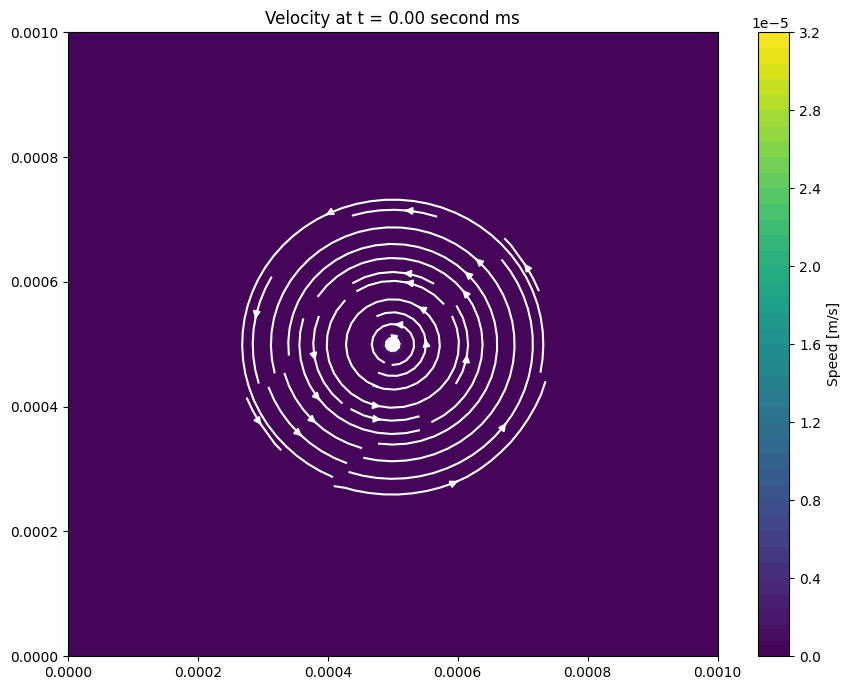

  0%|          | 1/10000 [00:01<4:06:28,  1.48s/it]

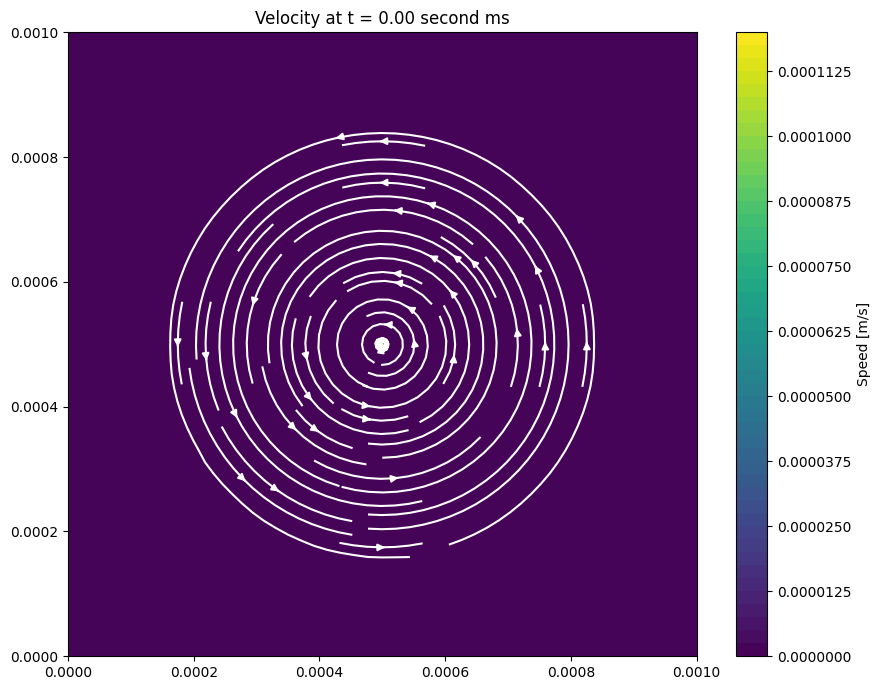

  0%|          | 2/10000 [00:02<3:51:06,  1.39s/it]

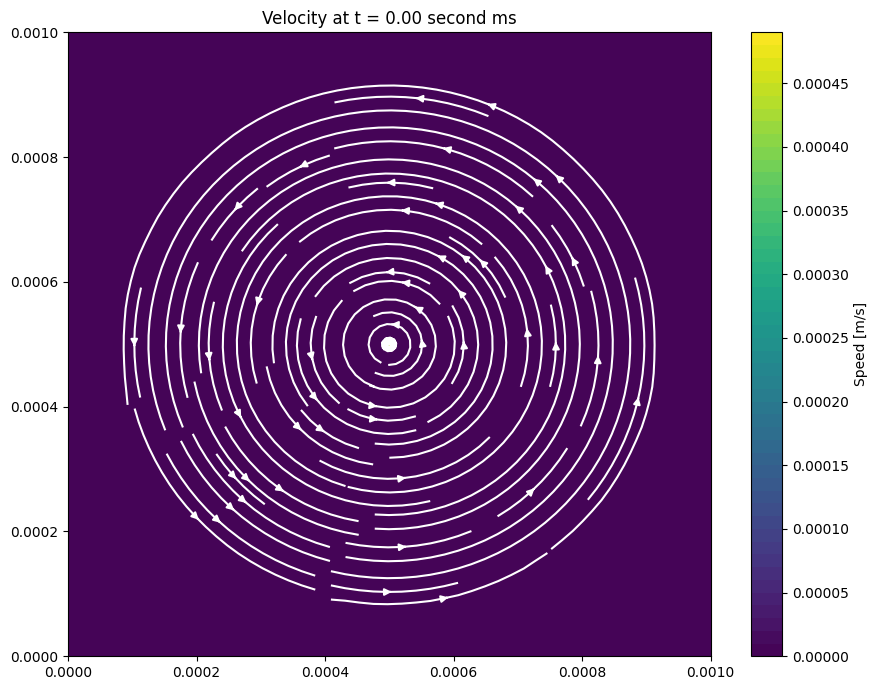

  0%|          | 3/10000 [00:04<3:54:26,  1.41s/it]

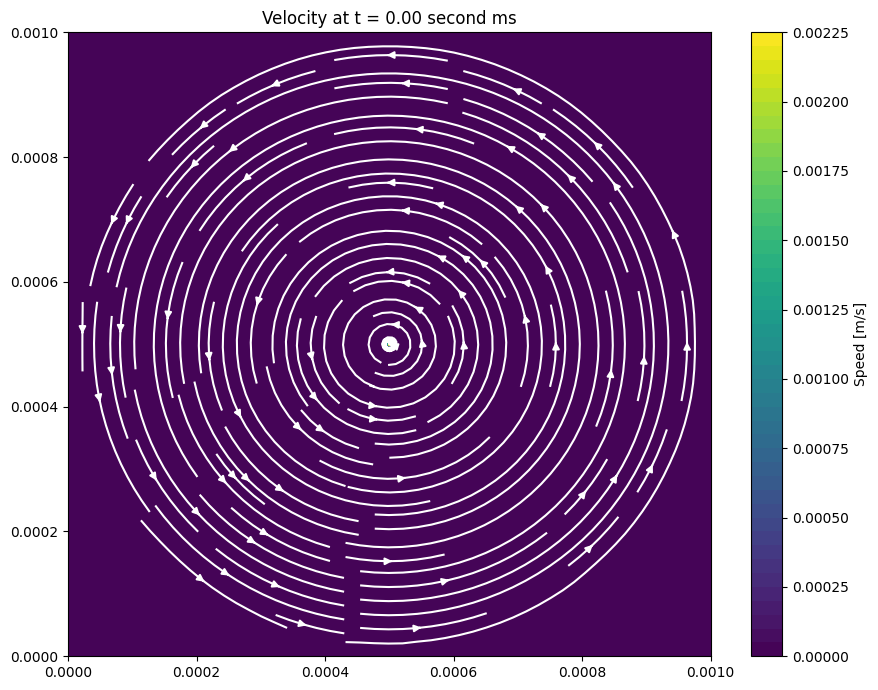

  0%|          | 4/10000 [00:05<3:53:48,  1.40s/it]

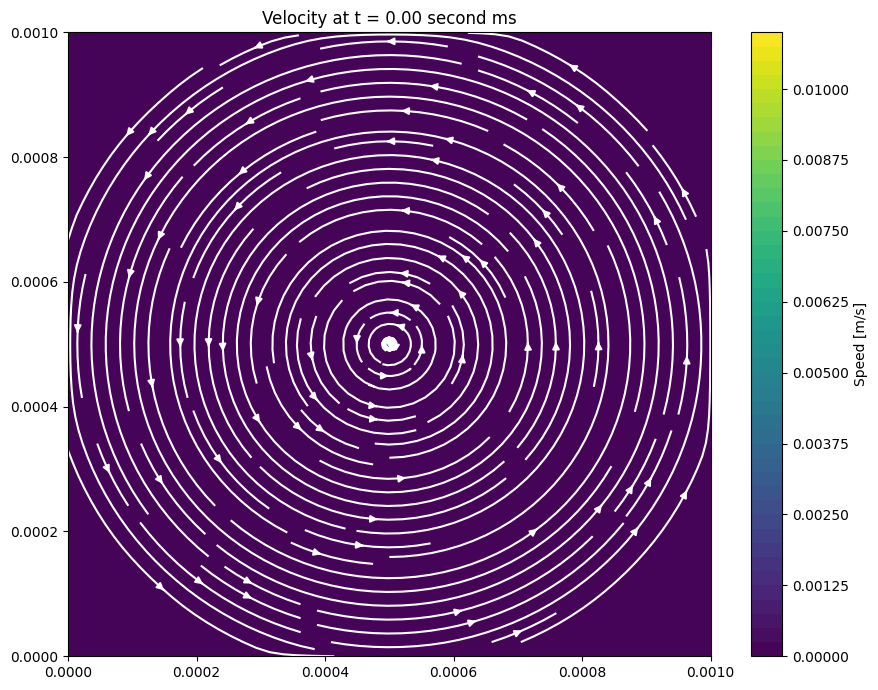

  0%|          | 5/10000 [00:07<3:54:47,  1.41s/it]

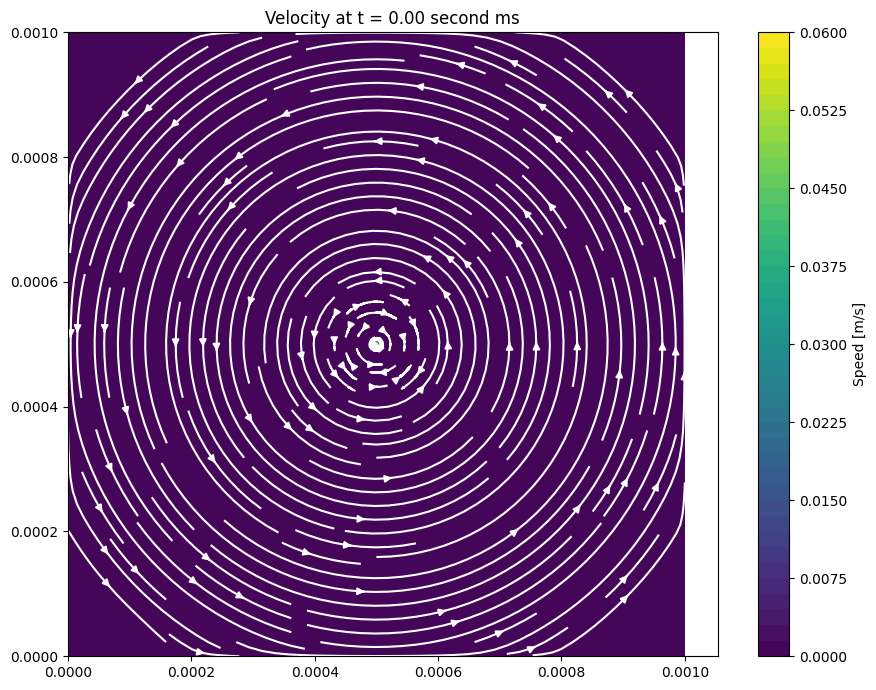

  0%|          | 6/10000 [00:09<4:27:43,  1.61s/it]


KeyboardInterrupt: 

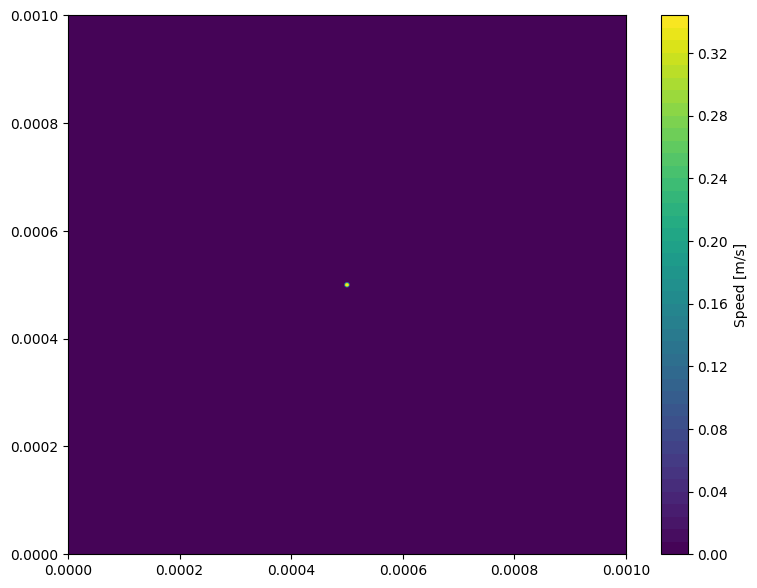

In [19]:
for n in tqdm(range(num_steps)):
    t = n * dt
    t_s = t.to("s").magnitude
    
    # Update flow
    omega = update_vorticity(omega, u, v, nu_m2_s, dx_m, dy_m, dt_s)
    omega = apply_vorticity_boundary_conditions(omega, psi, dx_m, dy_m)
    psi = apply_psi_boundary_conditions(psi)
    psi = solve_poisson(psi, omega, dx_m, dy_m)
    u, v = get_velocities(psi, dx_m, dy_m)
    
    # Update temperature
    Q = gaussian_heat_source(X, Y, t_s)
    T = update_temperature(T, u, v, alpha_m2_s, dx_m, dy_m, dt_s, Q)
    T = apply_temperature_bc(T)
    
    # Plot every 100 steps
    if n % 1 == 0:
        X_np = np.asarray(X)
        Y_np = np.asarray(Y)
        speed_np = np.asarray(jnp.sqrt(u**2 + v**2))
        T_np = np.asarray(T)
        
        # fig, (ax1, ax2) = plt.subplots(1, 1, figsize=(6, 6))
        fig, ax1 = plt.subplots(1, 1, figsize=(9, 7))
        
        # Temperature
        # c1 = ax1.contourf(X_np, Y_np, T_np, levels=50, cmap='hot')
        # plt.colorbar(c1, ax=ax1, label='Temperature [K]')
        # ax1.set_title(f'Temperature at t = {t} ms')
        
        # Velocity
        c2 = ax1.contourf(X_np, Y_np, speed_np, levels=50, cmap='viridis')
        plt.colorbar(c2, ax=ax1, label='Speed [m/s]')
        ax1.streamplot(X_np.T, Y_np.T, np.asarray(u).T, np.asarray(v).T, 
                       color='white', density=1.5)
        ax1.set_title(f'Velocity at t = {t*1000:.2f} ms')
        
        plt.tight_layout()
        plt.show()